In [33]:
# from torchvision.datasets import ImageFolder # 0.19.0
# import os
# import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import ConcatDataset
# from torch.utils.data import Dataset
from torchvision.transforms import v2
# from sklearn.model_selection import train_test_split
# import torch

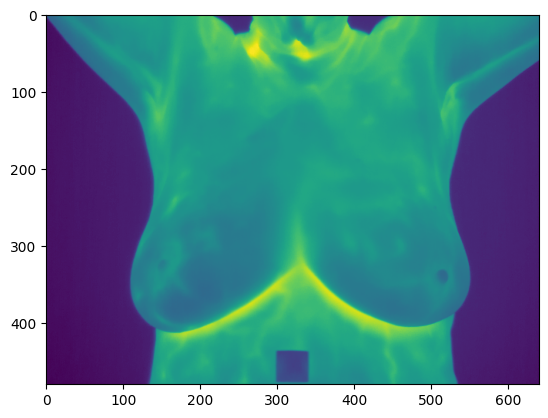

In [2]:
plt.imshow(np.loadtxt("dataset/MALIGNO/179/matrices_temperatura/PAC_179_001.txt"))

In [37]:
matrix = np.loadtxt("dataset/SANO/001/matrices_temperatura/PAC_1_001.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
34.95 20.0


In [38]:
matrix = np.loadtxt("dataset/SANO/001/matrices_temperatura/PAC_1_008.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
34.32 19.86


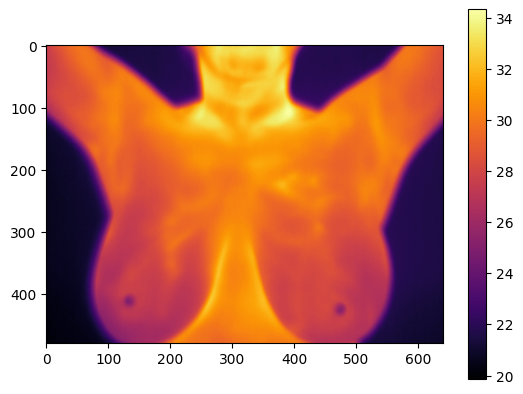

In [39]:
plt.imshow(matrix, cmap="inferno")
plt.colorbar()
plt.show()

In [40]:
img_gray = cv2.imread("dataset/SANO/001/imagenes/PAC_1_001.png")
print(img_gray.shape, img_gray.dtype, img_gray.min(), img_gray.max())

(480, 640, 3) uint8 2 255


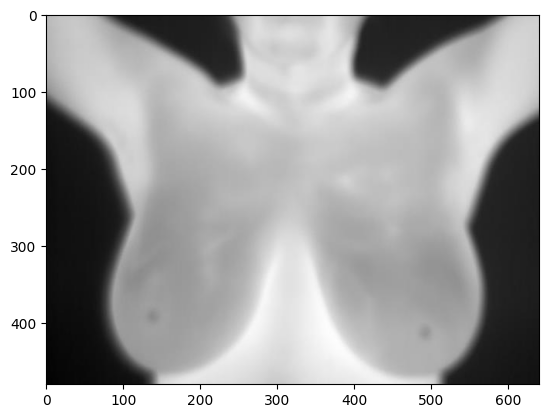

In [41]:
plt.imshow(img_gray, cmap="inferno")
plt.show()

In [34]:
import os
from torch.utils.data import Dataset
from utils import make_transforms
from preprocess import crop_breast

In [35]:
"""
Constante encontrada al iterar por todas las imágenes segmentadas, 
calcular su valor máximo de temperatura y devolver el máximo de todas.
"""

MAX_TEMPERATURE = 36.44

class ThermalDataset(Dataset):
  def __init__(self, image_dir: str, matrix_dir: str, transform = None, normalize = None, crop:bool = None):
    self.image_dir = image_dir
    self.matrix_dir = matrix_dir
    self.transform = transform
    self.normalize = normalize
    self.crop = crop
    self.images = os.listdir(image_dir) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos la imagen de la lista
    img_path = os.path.join(self.image_dir, self.images[index])

    # Leemos la imagen segmentada en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # uint8
    # img = Image.open(img_path)


    """ Carga de la matrix """

    # Entramos a la carpeta y conseguimos la matrix de la lista.
      # La razon por la que uso la misma lista de imagenes es porque la imagen y la matrix
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ matrizes: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN0.txt """
    """ segmentada: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png """
    
    if '-dir.png' in self.images[index]:
      matrix_path = os.path.join(self.matrix_dir, self.images[index].replace("-dir.png", ".txt"))
    elif '-esq.png' in self.images[index]:
      matrix_path = os.path.join(self.matrix_dir, self.images[index].replace("-esq.png", ".txt"))
      
    matrix = np.loadtxt(matrix_path, dtype=np.float32) # https://www.geeksforgeeks.org/import-text-files-into-numpy-arrays/

    """ Consigo la imagen segmentada con los valores de la matrix """

    segmented = np.where(img==0, 0, 1) # int64
    # segmented = img * matrix
    img_segmented = (matrix * segmented).astype(np.float32) # float32, shape (480, 640)

    if self.crop:
      img_crop = crop_breast(img_segmented) 

    # Le agrego un canal explícito 
    img_crop = np.expand_dims(img_crop, axis=2) # https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html

    if self.normalize:
      img = img / MAX_TEMPERATURE

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'DOENTES' 1
    # sino 0.

    label = self.image_dir.split('/')[2]
    if label == 'DOENTES':
      label = 1
    else:
      label = 0

    """ Convertir las imagenes en tensores y hacer resize """
    if self.transform:
      # Aplicamos las transformaciones a la imagen
      # print(type(img), img.shape)
      img_crop = self.transform(img_crop)
      
    return img, matrix, segmented, img_segmented, img_crop, label

In [36]:
TEST_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes"
TRAIN_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"

# Primero consigo la ruta de imagenes y matrices para cada uno de los pacientes

dirs_test = []
test_images = 0
test_matrices = 0
for category in os.listdir(TEST_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TEST_PATH, category)):
    # print(os.path.join(TEST_PATH, category, patient))
    dirs_test.append(os.path.join(TEST_PATH, category, patient))
    _, _, files = next(os.walk(os.path.join(TEST_PATH, category, patient, "Segmentadas")))
    # print(files)
    test_images += len(files)
    _, _, files = next(os.walk(os.path.join(TEST_PATH, category, patient, "Matrizes")))
    test_matrices += len(files)


dirs_train = []
train_images = 0
train_matrices = 0
for category in os.listdir(TRAIN_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TRAIN_PATH, category)):
    # print(os.path.join(TRAIN_PATH, category, patient))
    dirs_train.append(os.path.join(TRAIN_PATH, category, patient))
    _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Segmentadas")))
    train_images += len(files)
    try:
      _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Matrizes")))
      train_matrices += len(files)
    except:
      _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Matrizes de Temperatura")))
      train_matrices += len(files)



# Imprimo la cantidad de pacientes y datos que tenemos
print(f"Cantidad de pacientes para testeo: {len(dirs_test)}")
print(f"Cantidad de imagenes para testeo: {test_images}")
print(f"Cantidad de matrices para testeo: {test_matrices}")
print()
print(f"Cantidad de pacientes para entrenamiento: {len(dirs_train)}")
print(f"Cantidad de imagenes para entrenamiento: {train_images}")
print(f"Cantidad de matrices para entrenamiento: {train_matrices}")

Cantidad de pacientes para testeo: 9
Cantidad de imagenes para testeo: 240
Cantidad de matrices para testeo: 180

Cantidad de pacientes para entrenamiento: 47
Cantidad de imagenes para entrenamiento: 1282
Cantidad de matrices para entrenamiento: 948


In [37]:
test_datasets = []
for patient in dirs_test:
  folders = sorted(os.listdir(patient))
  # print(folders)
  test_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=make_transforms(), crop=True))

train_datasets = []
for patient in dirs_train:
  folders = sorted(os.listdir(patient))
  # print(folders)
  train_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=make_transforms(), crop=True))

test_dataset = ConcatDataset(test_datasets)
train_dataset = ConcatDataset(train_datasets)
full_dataset = ConcatDataset([test_dataset, train_dataset])

In [6]:
MAX_TEMPERATURE = 0
for record in full_dataset:
  max_temperature_record = record[4].squeeze(0).numpy().max()
  # print(max_temperature_record)
  if max_temperature_record > MAX_TEMPERATURE:
    MAX_TEMPERATURE = max_temperature_record
    print(MAX_TEMPERATURE)

33.529434
33.701107
34.5644
34.910213
35.15405
35.230194
35.712566
35.748875
35.838142


libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


36.025803
36.031696
36.089195
36.113438
36.125145
36.141724
36.247948
36.27094
36.433064


## Visualización de datos

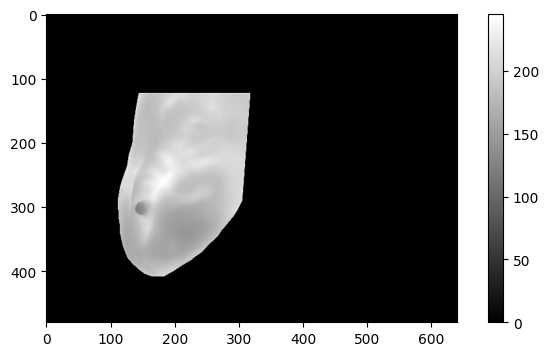

In [38]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(8, rows * 4))
    breast_types = {0: 'Normal', 1: 'Anormal'}

    np.random.seed(210)

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        img = dataset[idx][0] # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][5] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
        # plt.title(f"{breast_types[label]}")
        plt.colorbar()
        # plt.savefig('preprocess_gray')
    plt.show()

visualize_data(train_dataset, rows=1, cols=1)

1


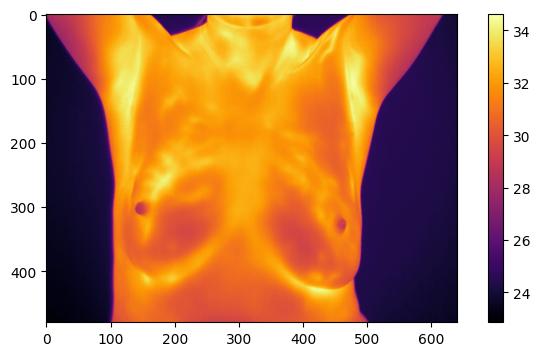

In [39]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(8, rows * 4))
    breast_types = {0: 'Normal', 1: 'Anormal'}

    np.random.seed(210)

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        # img = dataset[idx][1].squeeze(0) # Extraer la imagen y eliminar dimensiones singleton si es necesario
        img = dataset[idx][1] # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][5] # Extraer la etiqueta
        print(label)

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='inferno')
        # plt.title(f"{breast_types[label]}")
        # plt.axis('off')
        plt.colorbar()
        # plt.savefig('preprocess')
    plt.show()

visualize_data(train_dataset, rows=1, cols=1)

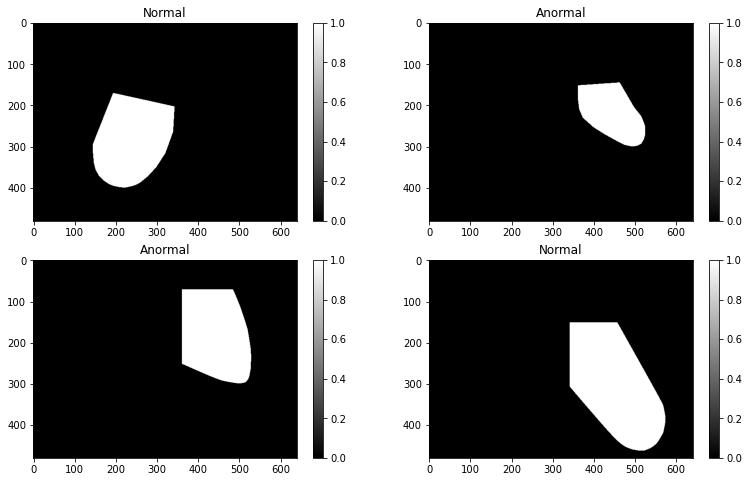

In [64]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(13, rows * 4))
    breast_types = {0: 'Normal', 1: 'Anormal'}


    np.random.seed(210)

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        # img = dataset[idx][1].squeeze(0) # Extraer la imagen y eliminar dimensiones singleton si es necesario
        img = dataset[idx][2] # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][5] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
        # plt.savefig('preprocess_mask')
    plt.show()

visualize_data(train_dataset, rows=2, cols=2)

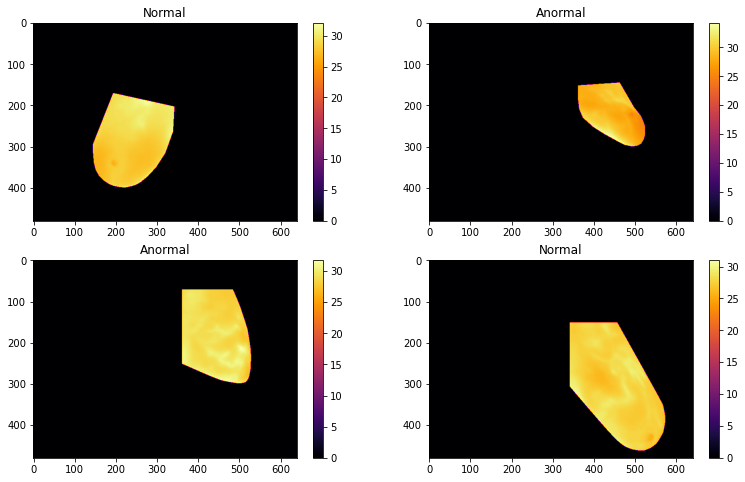

In [65]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(13, rows * 4))
    breast_types = {0: 'Normal', 1: 'Anormal'}


    np.random.seed(210)

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        img = dataset[idx][3] # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][5] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='inferno')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
        # plt.savefig('preprocess_segmented')
    plt.show()

visualize_data(train_dataset, rows=2, cols=2)

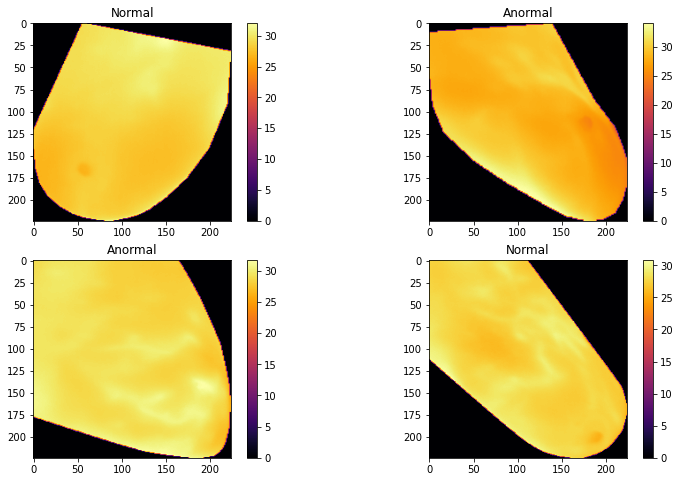

In [66]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(13, rows * 4))
    breast_types = {0: 'Normal', 1: 'Anormal'}

    np.random.seed(210)

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        img = dataset[idx][4].squeeze(0) # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][5] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='inferno')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
        plt.savefig('preprocess_cropped')
    plt.show()

visualize_data(train_dataset, rows=2, cols=2)

## Aumento de datos

In [42]:
transformations = [
    ("RandomHorizontalFlip", v2.RandomHorizontalFlip(p=1)),
    # ("RandomVerticalFlip", v2.RandomVerticalFlip(p=1)),
    ("RandomRotation degrees=45", v2.RandomRotation(degrees=45)),
    ("GaussianBlur k=5", v2.RandomApply([v2.GaussianBlur(kernel_size=5)], p=1)),
    ("RandomAffine 5%", v2.RandomApply([v2.RandomAffine(degrees=0, translate=(0.05, 0.05))], p=1))
]

In [68]:
def visualize_transformations(dataset, transformations, rows=3, cols=3):
    """
    Visualiza las imágenes con las transformaciones aplicadas individualmente.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        transformations (list): Lista de tuplas con el nombre y la transformación a aplicar.
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(8, rows * 4))
    np.random.seed(210)

    # Seleccionar un índice aleatorio del dataset
    idx = np.random.choice(len(dataset))
    original_img = dataset[idx][4] # Extraer la imagen original y eliminar dimensiones singleton si es necesario

    # Mostrar la imagen original
    plt.subplot(rows, cols, 1)
    plt.imshow(original_img.squeeze(0), cmap='inferno')
    plt.title("Original")
    plt.colorbar()

    # Aplicar y mostrar cada transformación
    for i, (name, transform) in enumerate(transformations, start=2):
        transformed_img = transform(original_img)
        plt.subplot(rows, cols, i)
        plt.imshow(transformed_img.squeeze(0), cmap='inferno')
        plt.title(name)
        plt.colorbar()

    # plt.savefig('preprocess_augmented')
    plt.show()

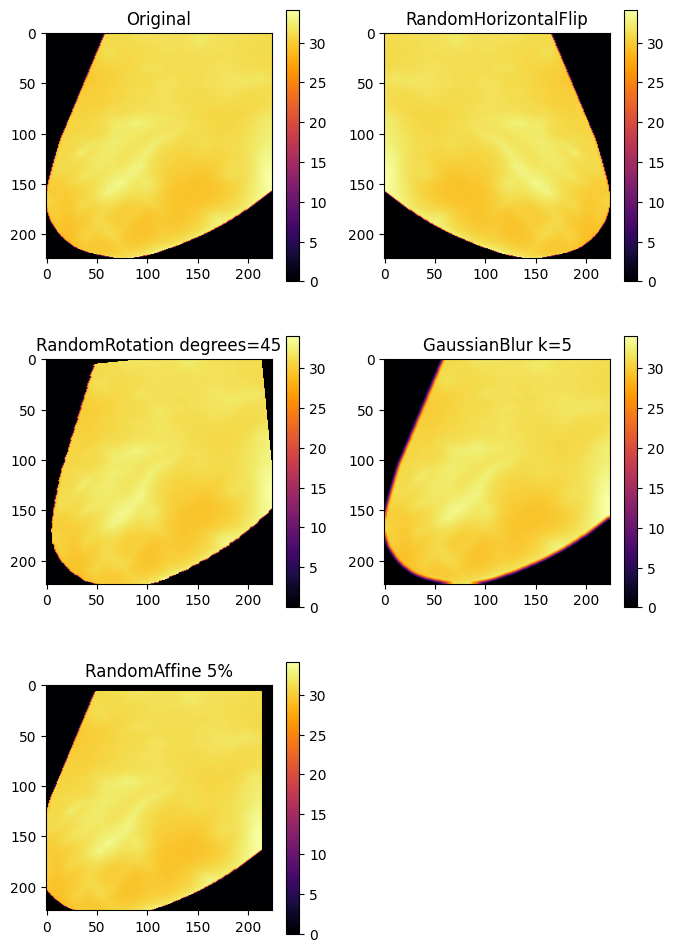

In [69]:
visualize_transformations(train_dataset, transformations, rows=3, cols=2)

## Intentando extraer parches

In [301]:
def extract_patches(image, patch_size, stride):
    # Extrae parches de una imagen usando PyTorch unfold
    # image: Tensor con la forma (C, H, W)
    # patch_size: tamaño del parche (patch_height, patch_width)
    # stride: pasos entre parches
    # C, H, W = image.shape
    patches = image.unfold(0, patch_size[0], stride[0]).unfold(1, patch_size[1], stride[1])
    
    print(patches.shape)
    # Los parches tienen la forma (C, num_patches_height, num_patches_width, patch_height, patch_width)
    patches = patches.contiguous().view(-1, patch_size[0], patch_size[0])
    
    # Cambiar la forma para obtener (num_patches, C, patch_height, patch_width)
    patches = patches.permute(0, 1, 2)
    return patches

In [302]:
import torch

np.random.seed(213)

# Seleccionar índices aleatorios del dataset
indices = np.random.choice(len(train_dataset), 1 * 1, replace=False)

for i, idx in enumerate(indices, start=1):
    # img = dataset[idx][1].squeeze(0) # Extraer la imagen y eliminar dimensiones singleton si es necesario
    img = full_dataset[idx][4] # Extraer la imagen y eliminar dimensiones singleton si es necesario
    print(img.shape)
    img = cv2.resize(np.transpose(img.numpy(), (1, 2, 0)), (224,224))
    print(img.shape)
    label = full_dataset[idx][5] # Extraer la etiqueta

# img = torch.tensor(img).unsqueeze(0)
img = torch.tensor(img)

torch.Size([1, 224, 224])
(224, 224)


In [303]:
img.shape

torch.Size([224, 224])

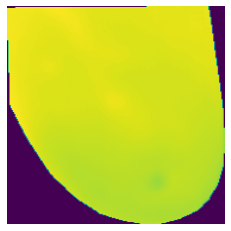

In [304]:
plt.imshow(img)
# plt.imshow(img)
plt.axis('off')
plt.show()

In [305]:
224//3

74

In [306]:
# patches = extract_patches(img, (224//3, 224//3), (224//3,224//3))
patches = extract_patches(img, (224//3, 224//3), (224//3, 224//3))

torch.Size([3, 3, 74, 74])


In [307]:
patches.shape

torch.Size([9, 74, 74])

In [310]:
def visualize_patches(patches, num_cols=8):
    num_patches = patches.shape[0]
    num_rows = (num_patches + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

    for i in range(num_patches):
        patch = patches[i].numpy()

        row = i // num_cols
        col = i % num_cols

        ax = axs[row, col] if num_rows > 1 else axs[col]
        ax.imshow(patch)
        ax.axis('off')

    for j in range(i + 1, num_rows * num_cols):
        row = j // num_cols
        col = j % num_cols
        ax = axs[row, col] if num_rows > 1 else axs[col]
        ax.axis('off')

    plt.show()

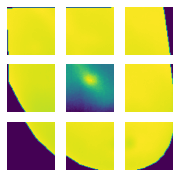

In [311]:
visualize_patches(patches, num_cols=3)